In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot, Reshape, Maximum, Normalization,LeakyReLU
from keras import optimizers
from tensorflow.keras.optimizers import Adam

#from keras.engine.topology import Layer
from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

!pip install iisignature
import iisignature

/Users/wws/sklearn-env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
#Senario Generators

#B-S generator
class BS(object):
    def __init__(self, S0, mu, sigma, N, R, T ):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.T = T

    def generate_spot_price_senario(self, N, R):
        S = np.ones((R,N+1))
        S[:,0] = self.S0 * np.ones(R)
        dt = self.T/N
        for i in range(1, N+1):
            S[:,i] = S[:,i-1] * np.exp( (self.mu - 1/2 * self.sigma **2 )* dt + self.sigma * np.sqrt(dt) * np.random.normal(size=(R)))
        return S


#CEM Senario Generator
class CEM(object):
    #N time disrectization
    #R number of trajectories
    #m number of instruments
    # cor is the correlation matrix
    def __init__(self, S0, sigma, gamma, mu,T):
        self.sigma = sigma
        self.gamma = gamma
        self.mu = mu
        self.T = T
        self.S0 = S0

    def generate_spot_price_senario(self, N, R):
        S = np.zeros((N+1,R))
        S[0] = [self.S0]*R
        dW = np.random.normal(0, np.sqrt(dt), size = (N,R))
        for i in range(1,N+1):
            lnS = np.log(S[i-1])
            dlnS = (self.mu - 1/2 * self.sigma**2 * (S[i-1])**(2*(self.gamma-1)))* (self.T / N) + self.sigma * S[i-1]**(self.gamma-1) * dW[i-1]
            S[i] = np.exp(lnS+ dlnS)
        return dW.T, S.T

class Heston(object):
    def __init__(self,S0,mu, nu0, theta, rho, kapa, xi,T):
        self.S0=S0
        self.nu0 = nu0
        self.theta = theta
        self.rho = rho
        self.kapa = kapa
        self.xi = xi
        self.mu = mu
        self.T = T

    def generate_spot_price_senario(self, N, R):
        dt = self.T/N
        dW = np.random.multivariate_normal(np.array([0,0]), np.array(np.array( [[1,self.rho],[self.rho,1]])), size = (R,N))* np.sqrt(dt)
        S = np.zeros((R,N+1))
        V = np.zeros((R,N+1))
        S[:,0]=[self.S0]* R
        V[:,0]=[self.nu0]*R
        for i in range(1,N+1):
            dnu = self.kapa*(self.theta - V[:,i-1])* dt + self.xi * np.sqrt(V[:,i-1]) * dW[:,i-1,0]
            V[:,i] = np.max(V[:,i-1]+dnu,0)
            dlnS = (self.mu - 1/2 * V[:,i-1]) * dt + np.sqrt(V[:,i-1]) * dW[:,i-1,1]
            S[:,i]= np.exp(np.log(S[:,i-1])+ dlnS)
        return S

In [ ]:
ra=5
def custom_loss(y_true,y_pred):
    #z = tf.keras.backend.exp(- y_pred[:]*ra)
    z = - tf.keras.backend.log(y_pred[:])
    z=tf.keras.backend.mean(z)
    return z

In [ ]:
#Markov agent
T=1
m = 1
d = 3
node = 32
N = 30
r = 0.05
dt= T/N
layers = []
def safe_exp(x):
    x_clipped = tf.clip_by_value(x, -20.0, 20.0)
    return tf.exp(x_clipped)
def safe_log(x):
    eps = 1e-6
    return tf.math.log(tf.clip_by_value(x, eps, tf.float32.max))
for i in range(N):
    for j in range(d):
        if j<d-1:
            layer = Dense(node, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        else:
            #need to have linear activation
            layer = Dense(m, activation='linear',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        layers = layers + [layer]
#markov strategy for CEM
price = Input(shape=(1,))
wealth = Input(shape=(1,))
inputs = [wealth]+ [price]

for i in range(N):
    price_next = Input(shape=(1,))
    dprice = Subtract()([price_next,price])
    alpha = Concatenate()([price, wealth])
    for k in range(i*d,i*d + d):
        alpha = layers[k](alpha)

    lnwealth = Lambda(lambda x: safe_log(x), output_shape = (m,))(wealth)


    inverse_price = Lambda(lambda x: 1/tf.keras.backend.maximum(x, 1e-6), output_shape = (m,))(price)

    helper2 = Multiply()([dprice, inverse_price])

    helper3 = Multiply()([alpha, helper2])

    helper4 = Lambda(lambda x: (1-x) * r * (T/N)  , output_shape = (m,))(alpha)

    helper22 = Lambda(lambda x: x - mu* (T/N), output_shape = (m,))(helper2)
    helper5 = Lambda(lambda x: - 1/2 * x**2  , output_shape = (m,))(helper22)
    alpsq = Lambda(lambda x:  x**2  , output_shape = (m,))(alpha)
    helper6 = Multiply()([alpsq, helper5])

    lnwealth = Add()([lnwealth, helper3,helper6])
    wealth = Lambda(lambda x: safe_exp(x), output_shape = (m,))(lnwealth)
    price = price_next
    inputs = inputs + [price_next]
outputs = wealth
model_CEM_Markov = Model(inputs = inputs, outputs = outputs)

# for i in range(N):
#     price_next = Input(shape=(1,))
#     dprice = Subtract()([price_next,price])
#     alpha = Concatenate()([price,wealth])
#     for k in range(i*d,i*d + d):
#         alpha = layers[k](alpha)

#     inverse_price = Lambda(lambda x: 1/x, output_shape = (m,))(price)
#     helper2 = Multiply()([dprice, inverse_price,wealth])
#     helper3 = Multiply()([alpha, helper2])

#     helper4 = Lambda(lambda x: (1-x) * r * (T/N)  , output_shape = (m,))(alpha)
#     helper5 = Multiply()([helper4, wealth])

#     wealth = Add()([wealth, helper3,helper5])
#     price = price_next
#     inputs = inputs + [price_next]

# #wealth = Lambda(lambda x: tf.keras.backend.maximum(x, 1e-30))(wealth)
# outputs = wealth
# model_CEM_Markov = Model(inputs = inputs, outputs = outputs)

In [ ]:
#Path dependent agent using signature
#At time t, we calculate the signature of depth 10 for each trajectory from time 0 to t. We input those signatures into our network.
#The strategy alpha_t depends on wealth, spot price at t and the signature of the tragectory from 0 to t
tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
def with_check(x, name):
    return tf.debugging.check_numerics(x, message=f"NaN or Inf in {name}")

tf.debugging.enable_check_numerics()
def safe_exp(x):
    x_clipped = tf.clip_by_value(x, -20.0, 20.0)
    return tf.exp(x_clipped)
def safe_log(x):
    eps = 1e-6
    return tf.math.log(tf.clip_by_value(x, eps, tf.float32.max))

depth = 4
dim_sig = iisignature.siglength(2, depth)
print(dim_sig)
m = 1
d = 6
node = 64
N = 30
layers = []

for i in range(N):
    for j in range(d):
        if j<d-5:
            layer = Dense(32, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        elif j==d-5:
            layer = Dense(10, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        elif j == d-4:
            layer = Dense(3, activation='linear',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        elif (j>d-4) and ( j<d-1) :
            layer = Dense(32, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        else:
            layer = Dense(1, activation='linear',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        layers = layers + [layer]

price = Input(shape=(1,))
wealth = Input(shape=(1,))
inputs = [wealth,price]


for i in range(N):
    price_next = Input(shape=(1,))
    dprice = Subtract()([price_next,price])
    signatures = Input(shape=(dim_sig,))
    #signatures = Normalization(axis = -1)(signatures)
    sig = signatures
    for k in range(i*d,i*d + d-4 +1):
        sig = layers[k](sig)

    alpha = Concatenate()([price,wealth,sig])
    for k in range(i*d + d-4 +1 ,i*d + d):
        alpha = layers[k](alpha)

    x = Lambda(lambda t: with_check(t, "my_dense_output"))(wealth)
    lnwealth = Lambda(lambda x: safe_log(x), output_shape = (m,))(wealth)
    x = Lambda(lambda t: with_check(t, "my_dense_output"))(lnwealth)

    inverse_price = Lambda(lambda x: 1/x, output_shape = (m,))(price)
    x = Lambda(lambda t: with_check(t, "my_dense_output"))(inverse_price)

    helper2 = Multiply()([dprice, inverse_price])

    helper3 = Multiply()([alpha, helper2])

    helper4 = Lambda(lambda x: (1-x) * r * (T/N)  , output_shape = (m,))(alpha)

    helper22 = Lambda(lambda x: x - mu* (T/N), output_shape = (m,))(helper2)
    helper5 = Lambda(lambda x: - 1/2 * x**2  , output_shape = (m,))(helper22)
    alpsq = Lambda(lambda x:  x**2  , output_shape = (m,))(alpha)
    helper6 = Multiply()([alpsq, helper5])

    lnwealth = Add()([lnwealth, helper3,helper6])
    wealth = Lambda(lambda x: safe_exp(x), output_shape = (m,))(lnwealth)
    price = price_next
    inputs = inputs + [price_next]
    inputs = inputs + [signatures]
outputs = wealth
model_Signature = Model(inputs = inputs, outputs = outputs)

INFO:tensorflow:Enabled check-numerics callback in thread MainThread
30


In [ ]:
#A second version of Path dependent agent
#This agent use second variation of ln S_t to estimate the volatility v_t

def with_check(x, name):
    return tf.debugging.check_numerics(x, message=f"NaN or Inf in {name}")

tf.debugging.enable_check_numerics()
def safe_exp(x):
    x_clipped = tf.clip_by_value(x, -20.0, 20.0)
    return tf.exp(x_clipped)
def safe_log(x):
    eps = 1e-6
    return tf.math.log(tf.clip_by_value(x, eps, tf.float32.max))

m = 1
d = 3
node = 32
N = 30
layers = []
for i in range(N):
    for j in range(d):
        if j<d-1:
            layer = Dense(node, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        else:
            #need to have linear activation
            layer = Dense(m, activation='linear',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                         name=str(i)+str(j))
        layers = layers + [layer]

price = Input(shape=(1,))
wealth = Input(shape=(1,))
inputs = [wealth,price]


for i in range(N):
    price_next = Input(shape=(1,))
    dprice = Subtract()([price_next,price])
    estimation_nu = Input(shape=(1,))
    #signatures = Normalization(axis = -1)(signatures)
    alpha = Concatenate()([price,wealth,estimation_nu])
    x = Lambda(lambda t: with_check(t, "my_dense_output"))(alpha)
    for k in range(i*d,i*d + d):
        alpha = layers[k](alpha)
        x = Lambda(lambda t: with_check(t, "my_dense_output"))(alpha)
    x = Lambda(lambda t: with_check(t, "my_dense_output"))(wealth)
    lnwealth = Lambda(lambda x: safe_log(x), output_shape = (m,))(wealth)
    x = Lambda(lambda t: with_check(t, "my_dense_output"))(lnwealth)

    inverse_price = Lambda(lambda x: 1/x, output_shape = (m,))(price)
    x = Lambda(lambda t: with_check(t, "my_dense_output"))(inverse_price)

    helper2 = Multiply()([dprice, inverse_price])

    helper3 = Multiply()([alpha, helper2])

    helper4 = Lambda(lambda x: (1-x) * r * (T/N)  , output_shape = (m,))(alpha)

    helper22 = Lambda(lambda x: x - mu* (T/N), output_shape = (m,))(helper2)
    helper5 = Lambda(lambda x: - 1/2 * x**2  , output_shape = (m,))(helper22)
    alpsq = Lambda(lambda x:  x**2  , output_shape = (m,))(alpha)
    helper6 = Multiply()([alpsq, helper5])

    lnwealth = Add()([lnwealth, helper3,helper6])
    wealth = Lambda(lambda x: safe_exp(x), output_shape = (m,))(lnwealth)
    price = price_next
    inputs = inputs + [price_next]
    inputs = inputs + [estimation_nu]
outputs = wealth
model_path_v2 = Model(inputs = inputs, outputs = outputs)

INFO:tensorflow:Enabled check-numerics callback in thread MainThread


In [ ]:
#function to prepare train data or test data for path dependent agents
def construct_data_for_model_signature(S,X0):
    R= len(S[:,0])
    N = len(S[0,:])-1
    a = 1e1
    data = [X0 * np.ones((R,1))]+[S[:,0].reshape(R,1)]
    for i in range(1,N+1):
        price = [S[:,i].reshape(R,1)]
        available_logprices = np.log(S[:,0:i])
        signatures = np.zeros((R, dim_sig))
        for j in range(R):
            p1 = available_logprices[j].reshape(-1, 1)
            p2 = np.append(available_logprices[j,1:],available_logprices[j,-1]).reshape(-1, 1)
            #p3 = np.linspace(0,1,31)[0:i].reshape(-1, 1)
            path =  a*np.concatenate((p1,p2),axis = 1)
            signatures[j] = iisignature.sig(path, depth)
        data = data + price
        data = data + [signatures]
    return data

#construct data:
def construct_data_for_model_path(S,X0):
    n = 3
    R= len(S[:,0])
    N = len(S[0,:])-1
    data = [X0 * np.ones((R,1))]+[S[:,0].reshape(R,1)]
    for i in range(1,N+1):
        price = [S[:,i].reshape(R,1)]
        logprices = np.log(S[:,np.max([i-n,0]):np.min([i+n,N+1])])
        w = len(logprices[0,:])
        if w <2:
            su = np.zeros((R,))
        else:
            su = 0
            for j in range(1,w):
                su = su + (logprices[:,j]-logprices[:,j-1])**2
            su = su/((w-1)*(1/N))

        data = data + price
        data = data + [su.reshape(R,1)]
    return data

In [ ]:
#We train agents defined above in the fwllowing CEM setting
S0= 1
sigma = 0.2
gamma = 2
mu = 0.1
Ktrain = 10**5
X0 = 1
C = CEM(S0,sigma,gamma,mu, T)
_, S = C.generate_spot_price_senario(30, Ktrain)

In [ ]:
xtrain = [X0 * np.ones((Ktrain, m))]+ [S[:,i].reshape((Ktrain,m)) for i in range(len(S[0]))]
ytrain = np.zeros(Ktrain)


In [ ]:
model_CEM_Markov.compile(optimizer='adam',loss=custom_loss)

In [ ]:
for i in range(1):
    model_CEM_Markov.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: -0.0932
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1196
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1174
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1163
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1179
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1195
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1187
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1186
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1201
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1177


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
-0.118696906


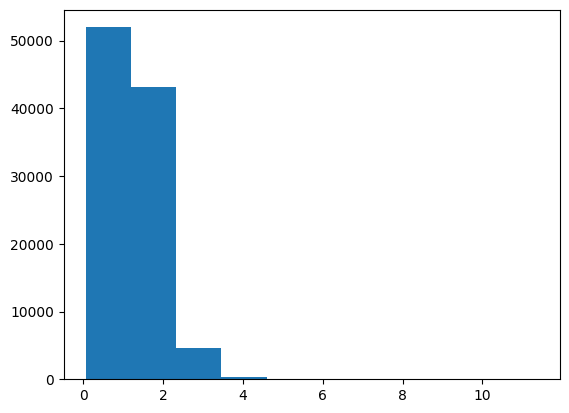

1.2573248
0.58460206


In [ ]:
y_pred = model_CEM_Markov.predict(xtrain)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
-0.115410045


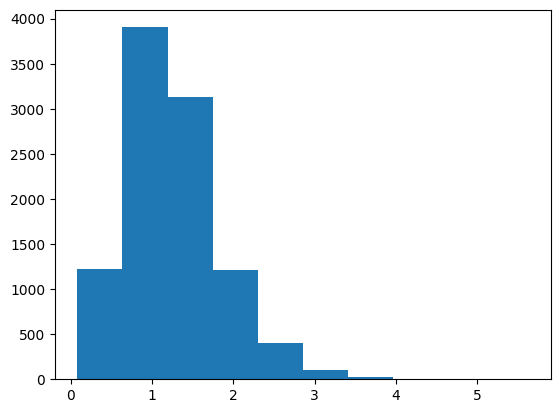

1.252576
0.5752884


In [ ]:
#Test for the trained Martov Agent on CEM senario
Ktest = 10000
T=1
D = CEM(S0,sigma,gamma,mu,T)
_ , S_test = D.generate_spot_price_senario(N, Ktest)
xtest = [X0 * np.ones((Ktest, m))]+ [S_test[:,i].reshape((Ktest,m)) for i in range(len(S_test[0]))]
y_pred = model_CEM_Markov.predict(xtest)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

In [ ]:
xtrain = construct_data_for_model_signature(S,X0)
opt = Adam(learning_rate=1e-4)
model_Signature.compile(optimizer=opt,loss=custom_loss)

In [ ]:
for i in range(1):
    model_Signature.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=512)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - loss: 0.0353
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.0752
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -0.1033
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.1091
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.1162
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.1173
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -0.1170
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.1175
Epoch 9/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: -0.1200
Epoch 10/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: -0.1212


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 201s 64ms/step
-0.12154978


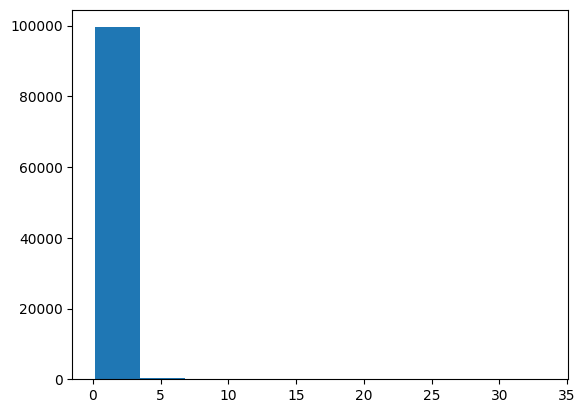

1.2536874
0.593178


In [ ]:
y_pred = model_Signature.predict(xtrain)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 197s 63ms/step
-0.12154978


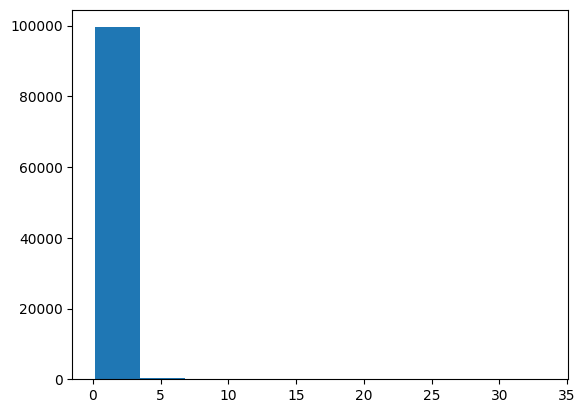

1.2536874
0.593178


In [ ]:
Ktest = 1000
D = CEM(S0,sigma,gamma,mu,T)
_ , S_test = D.generate_spot_price_senario(N, Ktest)
xtest = construct_data_for_model_signature(S,X0)
y_pred = model_Signature.predict(xtest)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

For the CEM model the Markov agent and the path dependent agent show similar power.
The Markov model has average return of 1.25 and path dependent agent have average return of 1.25
The reseaon is that the strategy only depend on wealth_t and price_t, it does not need the information of whole path to determine the strategy.

True


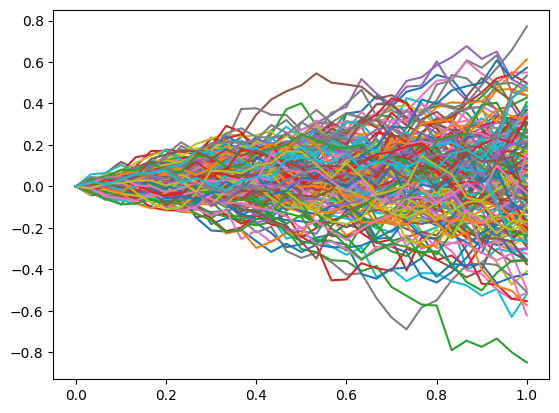

In [ ]:
#we test the markov agent and path dependent agent in the Heston model

#parameters for the Heston model
T = 1
S0 = 1
X0=1
mu = 0.3
r = 0.05
kapa = 2
theta = 0.1
nu0 = 0.04
rho = -0.7
xi = 0.1
N=30

print(2* kapa*theta > xi**2)

Ktrain =100000
H = Heston(S0,mu, nu0, theta, rho, kapa, xi,T)
S = H.generate_spot_price_senario(N,Ktrain)
plt.plot(np.linspace(0,1,N+1),np.log10(S[30:200,:]).T )
plt.show()

In [ ]:
#train the Markov agent
xtrain = [X0 * np.ones((Ktrain, m))]+ [S[:,i].reshape((Ktrain,m)) for i in range(len(S[0]))]
model_CEM_Markov.compile(optimizer='adam',loss=custom_loss)
for i in range(1):
    model_CEM_Markov.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: -0.0259
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1904
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1937
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1925
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1938
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1950
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1938
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1935
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1957
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: -0.1942


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step
-0.1949567


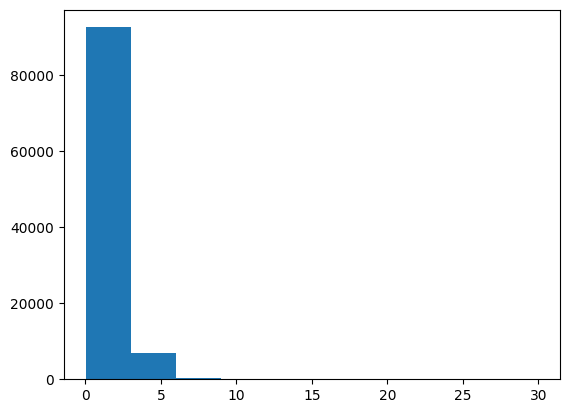

1.4844333
1.0240312


In [ ]:
#performence of Markov agent on training data set
y_pred = model_CEM_Markov.predict(xtrain)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
-0.20794211


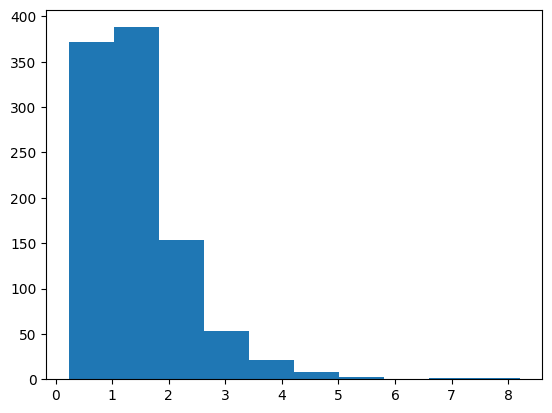

1.4409378
0.8747847


In [ ]:
#performence of Markov agent on test set
Ktest = 1000
S_test = H.generate_spot_price_senario(30,Ktest)
xtest = [X0 * np.ones((Ktest, m))]+ [S_test[:,i].reshape((Ktest,m)) for i in range(len(S_test[0]))]
y_pred = model_CEM_Markov.predict(xtest)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

In [ ]:
#Train the Signature agent
xtrain = construct_data_for_model_signature(S,X0)
ytrain = np.zeros(Ktrain)

In [ ]:
opt = Adam(learning_rate=3e-4)
model_Signature.compile(optimizer=opt,loss=custom_loss)
for i in range(1):
    model_Signature.fit(x=xtrain,y=ytrain, epochs=10,verbose=True,batch_size=100)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: -0.0663
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: -0.1797
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: -0.1901
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: -0.1945
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: -0.1963
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: -0.1987
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: -0.2025
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: -0.2014
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: -0.2049
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: -0.2037


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 202s 64ms/step
-0.20853847


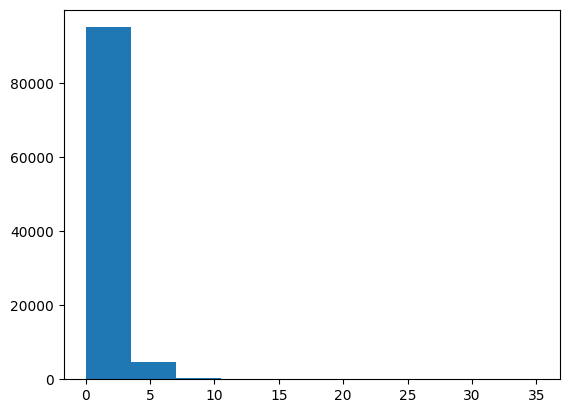

1.5249351
1.1021621


In [ ]:
#performence of Signature agent on training set
y_pred = model_Signature.predict(xtrain)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step
-0.24986081


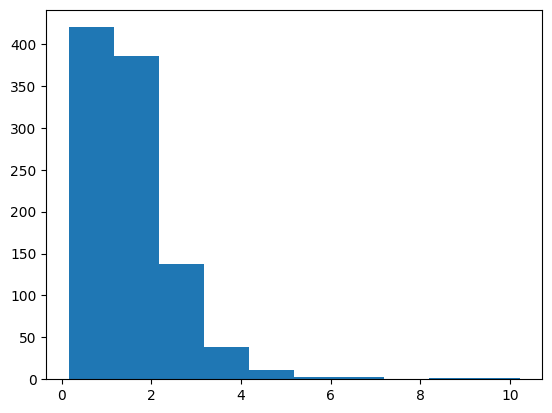

1.5309298
0.9824478


In [ ]:
#performence of Signature agent on test set
Ktest = 1000
S_test = H.generate_spot_price_senario(30,Ktest)
xtest = construct_data_for_model_signature(S_test,X0)
y_pred = model_Signature.predict(xtest)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

In [ ]:
#Train the path dependent agent using second variantion
xtrain = construct_data_for_model_path(S,X0)
ytrain = np.zeros(Ktrain)

In [ ]:
opt = Adam(learning_rate=1e-4)
model_path_v2.compile(optimizer=opt,loss=custom_loss)
for i in range(1):
    model_path_v2.fit(x=xtrain,y=ytrain, epochs=20,verbose=True,batch_size=500)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.5176
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.0684
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1508
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1700
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1789
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1814
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1874
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1856
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1871
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1896
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1914
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1945
Epoch 13/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1871
Epoch 14/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -0.1947
Epoch 15/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step
-0.19476153


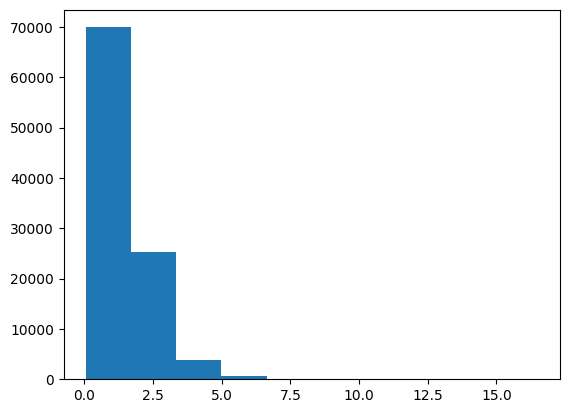

1.4674915
0.9638764


In [ ]:
#performence on traning set
y_pred = model_path_v2.predict(xtrain)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
-0.19973181


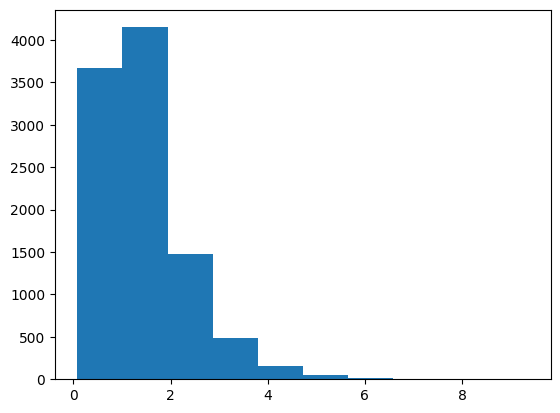

1.4435096
0.8810894


In [ ]:
#performence on test set
Ktest = 10000
H = Heston(S0,mu, nu0, theta, rho, kapa, xi,T)
S_test = H.generate_spot_price_senario(30,Ktest)
xtest = construct_data_for_model_path(S_test,X0)
y_pred = model_path_v2.predict(xtest)
print(np.mean(-np.log(y_pred[:])))
plt.hist(y_pred[:])
plt.show()
print(np.mean(y_pred[:]))
print(np.std(y_pred[:]))

Average retuerns results for the Heston model:\\\
For Markov agent: 1.48 for the training set and 1.44 for test set\\\
For path dependent agent using signature: 1.53 for training set and 1.53 for test set\\\
For path dependent agent using 2 variantion of ln S: 1.47 for training set and 1.44 for test set\\\
We see that the agent using signature behaves the best for Heston model, since in this case the strategy_t depend also on v_t which need infomation of the path to decide.
